In [1]:
%matplotlib inline

In [159]:
from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

import nengo
import nengolib

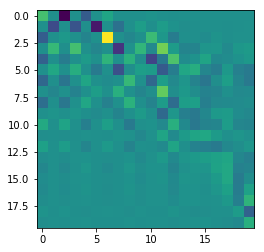

/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/nengolib/signal/system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


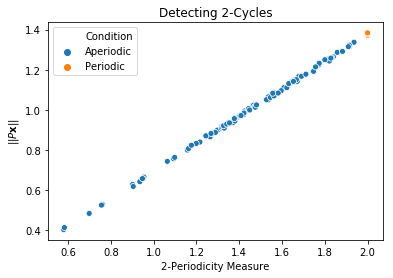

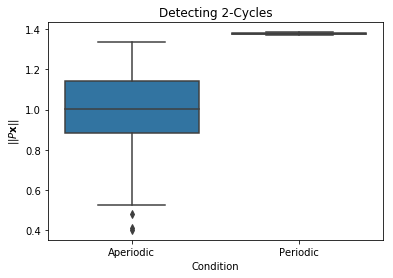

1.391066623110518


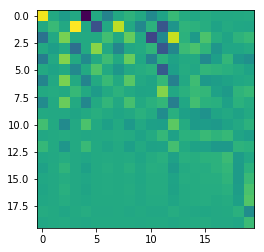

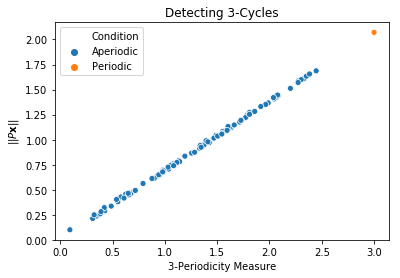

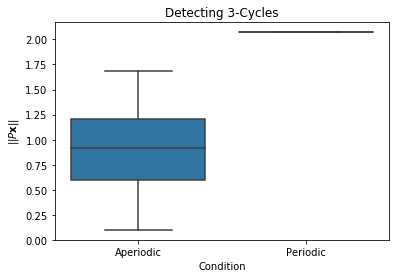

2.311237495100658


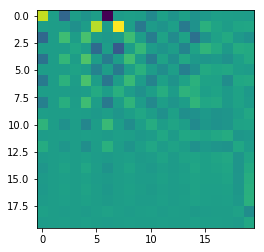

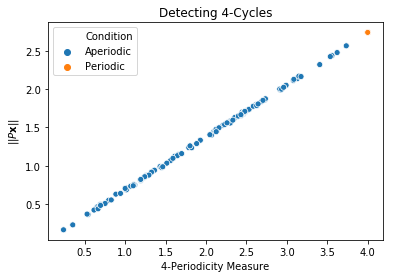

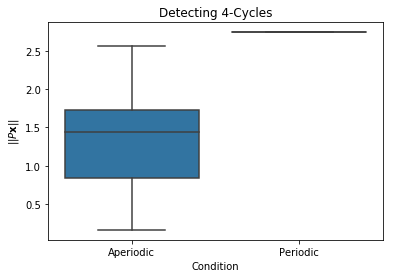

2.056561735544654


In [407]:
from scipy.linalg import expm, inv

from nengolib.networks.rolling_window import readout


def canonical_basis(dimensions, t):
    """Temporal basis functions for PadeDelay in canonical form."""
    t = np.atleast_1d(t)
    B = np.asarray([readout(dimensions, r) for r in t])
    return B


def basis(T, dimensions, t):
    """Temporal basis functions for realized PadeDelay."""
    # Undo change of basis from realizer, and then transform into window
    B = canonical_basis(dimensions, t)
    return B.dot(T)


def inverse_basis(T, dimensions, t):
    """Moore-Penrose pseudoinverse of the basis functions."""
    B = basis(T, dimensions, t)
    return inv(B.T.dot(B)).dot(B.T)


def normalize(x):
    return x / np.std(x)


def compute_periodicity(x, cycles):
    parts = np.asarray(np.split(x, cycles))
    assert parts.shape == (cycles, len(x) // cycles)
    combined = np.sum(parts, axis=0)
    assert combined.shape == (len(x) // cycles,)
    return np.std(combined)


def go(
    cycles=5,
    lmbda=1e-6,  # for basis solver
    n_eval_points=1000,  # for basis solver
    dt=0.001,
    freq=10,
    theta=0.480,  # gives highly-divisble n_steps
    order=20,
    n_trials=100,
    seed=0,
):
    n_steps = int(theta / dt)
    assert np.allclose(n_steps, theta / dt)
    n_steps_per_cycle = int(n_steps / cycles)
    assert np.allclose(n_steps_per_cycle, n_steps / cycles)
    t = np.arange(0, theta, dt)

    pade_error = np.abs(nengolib.synapses.pade_delay_error(theta*freq, order=order))
    assert pade_error < 1e-2, pade_error

    rng = np.random.RandomState(seed=0)

    def generate_cyclic():
        process = nengo.processes.WhiteSignal(high=freq, period=theta/cycles, y0=0)
        signal = process.run(theta/cycles, dt=dt, rng=rng).squeeze()
        return normalize(np.tile(signal, cycles))

    def generate_acyclic():
        process = nengo.processes.WhiteSignal(high=freq, period=theta, y0=0)
        return normalize(process.run(theta, dt=dt, rng=rng).squeeze())

    realizer = nengolib.signal.Balanced()
    realization_result = realizer(nengolib.synapses.PadeDelay(theta, order=order))
    sys = realization_result.realization

    I = np.eye(order)
    H = sum(expm(sys.A * i * theta / cycles) for i in range(cycles))
    #P = H.dot(inv(H.T.dot(H) + lmbda*np.max(np.abs(H))*I))
    #P = inv(H).T.dot(inv(H))

    tfull = np.linspace(0, 1, n_eval_points)
    tpart = np.linspace(1-1/cycles, 1, n_eval_points)
    #Bfull = basis(realization_result.T, order, tfull)
    Bpart = basis(realization_result.T, order, tpart)
    Binc = inverse_basis(realization_result.T, order, tfull)
    assert Bfull.shape == (n_eval_points, order)
    assert Bpart.shape == (n_eval_points, order)
    assert Binc.shape == (order, n_eval_points)

    #R, _ = nengo.solvers.LstsqL2(reg=lmbda)(Bfull, Bpart)
    R = Binc.dot(Bpart)    
    P = R.dot(H)
    
    plt.figure()
    plt.imshow(P)
    plt.show()
    
    ideal_label = "%d-Periodicity Measure" % cycles
    output_label = r"$\|\| P\mathbf{x} \|\|$"
    
    data = defaultdict(list)
    for i in range(n_trials):
        for condition, u in (('Aperiodic', generate_acyclic()),
                             ('Periodic', generate_cyclic()),):
            x = sys.X.filt(u, y0=0, dt=dt)[-1, :]
            #x_hat = H.dot(x)
            x_hat = P.dot(x)
            
            #x0 = sys.X.filt(u[:len(u) // cycles], y0=0, dt=dt)[-1, :]
            #x_hat = x0  #H.dot(x0)

            data['Condition'].append(condition)
            data['Seed'].append(i)
            data[output_label].append(np.linalg.norm(x_hat))
            data[ideal_label].append(compute_periodicity(u, cycles))
            
    df = DataFrame(data)
    
    plt.figure()
    plt.title("Detecting %d-Cycles" % cycles)
    sns.scatterplot(data=df, x=ideal_label, y=output_label, hue="Condition")
    plt.show()

    plt.figure()
    plt.title("Detecting %d-Cycles" % cycles)
    sns.boxplot(data=df, x="Condition", y=output_label)
    plt.show()
    
    print(df[df["Condition"] == "Periodic"][output_label].mean() /
          df[df["Condition"] == "Aperiodic"][output_label].mean())
    
for cycles in (2, 3, 4):
    go(cycles=cycles)

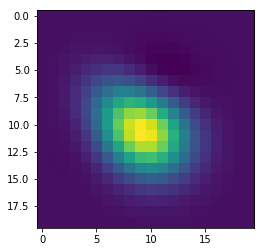

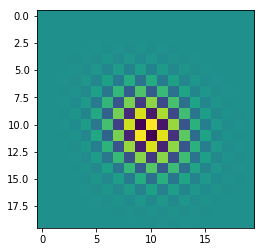

"\nplt.figure()\nplt.plot(tfull, Bfull)\nplt.plot(tpart, Bpart, linestyle='--')\nplt.show()\n\nplt.figure()\nplt.plot(tfull, Bfull)\nplt.plot(tpart, Bfull.dot(R), linestyle='--')\nplt.show()\n\nx = 2*np.random.choice(2, order) - 1\nplt.figure()\nplt.plot(tfull, Bfull.dot(x))\nplt.plot(tpart, Bfull.dot(R.dot(x)))\nplt.show()\n"

In [415]:
#from matplotlib.colors import LogNorm

theta = 1
order = 20

realizer = nengolib.signal.Hankel()
realization_result = realizer(nengolib.synapses.PadeDelay(theta, order=order))
sys = realization_result.realization

tfull = np.linspace(0, 1, 1000)
Bfull = basis(realization_result.T, order, tfull)

Binc = inverse_basis(realization_result.T, order, tfull)

for cycles in [2]:
    for tpart in (np.linspace(0, 1/cycles, len(tfull)),  # start
                  np.linspace(1-1/cycles, 1, len(tfull)),  # end
                 ):

        Bpart = basis(realization_result.T, order, tpart)

        assert Bfull.shape == (len(tfull), order)
        assert Bpart.shape == (len(tfull), order)

        R, _ = nengo.solvers.LstsqL2(reg=0.1)(Bfull, Bpart)
        #R = Binc.dot(Bpart)
        assert R.shape == (order, order)

        plt.figure()
        plt.imshow(R)
        plt.show()

'''
plt.figure()
plt.plot(tfull, Bfull)
plt.plot(tpart, Bpart, linestyle='--')
plt.show()

plt.figure()
plt.plot(tfull, Bfull)
plt.plot(tpart, Bfull.dot(R), linestyle='--')
plt.show()

x = 2*np.random.choice(2, order) - 1
plt.figure()
plt.plot(tfull, Bfull.dot(x))
plt.plot(tpart, Bfull.dot(R.dot(x)))
plt.show()
'''